In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [7]:
words = open("names.txt","r").read().splitlines()
len(words)

32033

In [8]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [9]:
vocab_size = len(itos)

In [14]:
block_size = 3

def build_datasets(words):
    X,Y =[],[]
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [15]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])
Xdev, Ydev = build_datasets(words[n1:n2])
Xte, Yte = build_datasets(words[n2:])

In [37]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        # print(x)
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [80]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps =eps
        self.momentum = momentum
        self.traning = True
        self.gamma = troch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with troch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
            return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [81]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [82]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,vocab_size)
]
# layers = [
#     Linear(n_embd*block_size, n_hidden), #Tanh(),
#     Linear(n_hidden,n_hidden), #Tanh(),
#     Linear(n_hidden,n_hidden), #Tanh(),
#     Linear(n_hidden,n_hidden), #Tanh(),
#     Linear(n_hidden,n_hidden), #Tanh(),
#     Linear(n_hidden,vocab_size)
# ]

with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [83]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x= layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    
    for p in parameters:
        p.grad=None
    loss.backward()

    lr = 0.1 if i <150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    if i >= 1000:
        break

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

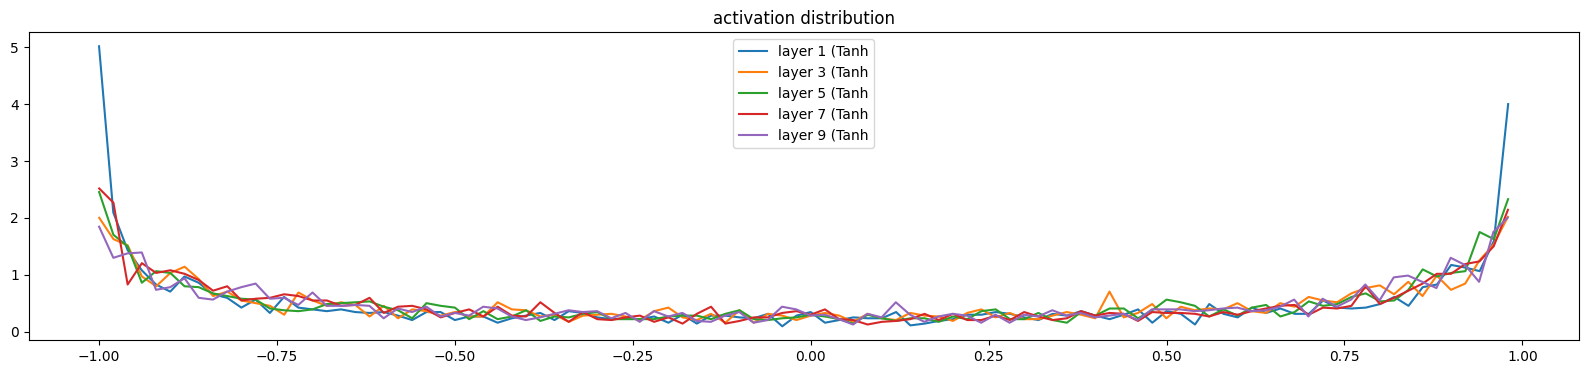

In [84]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000024, std 3.353991e-03
layer 3 (      Tanh): mean +0.000012, std 3.157344e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

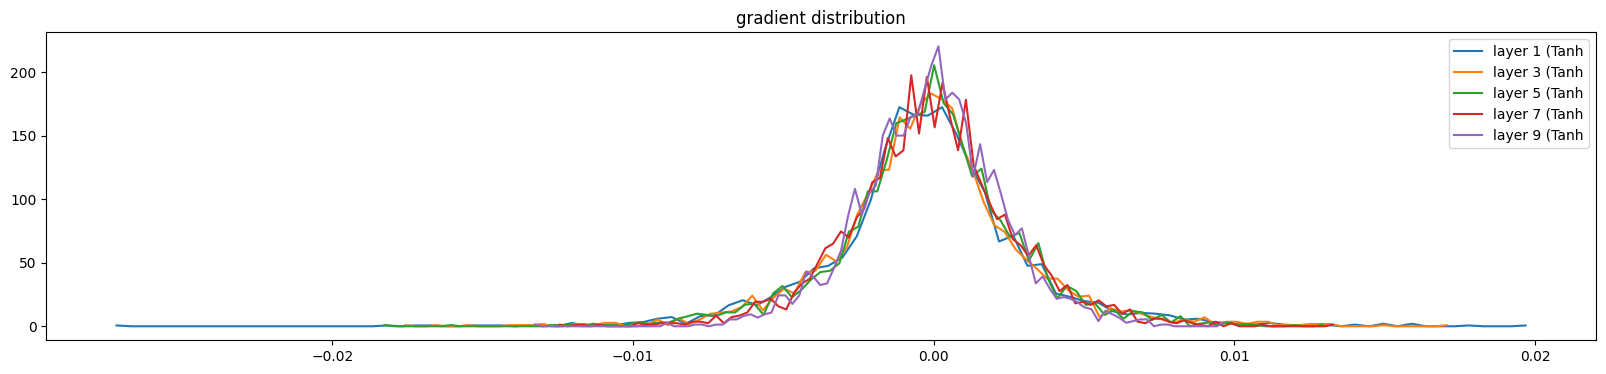

In [85]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000980 | std 1.189170e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005290e-02 | grad:data ratio 3.214555e-02
weight (100, 100) | mean +0.000033 | std 7.821210e-03 | grad:data ratio 4.653361e-02
weight (100, 100) | mean -0.000107 | std 6.655619e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086038e-03 | grad:data ratio 3.605767e-02
weight (100, 100) | mean -0.000077 | std 5.075619e-03 | grad:data ratio 3.015268e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


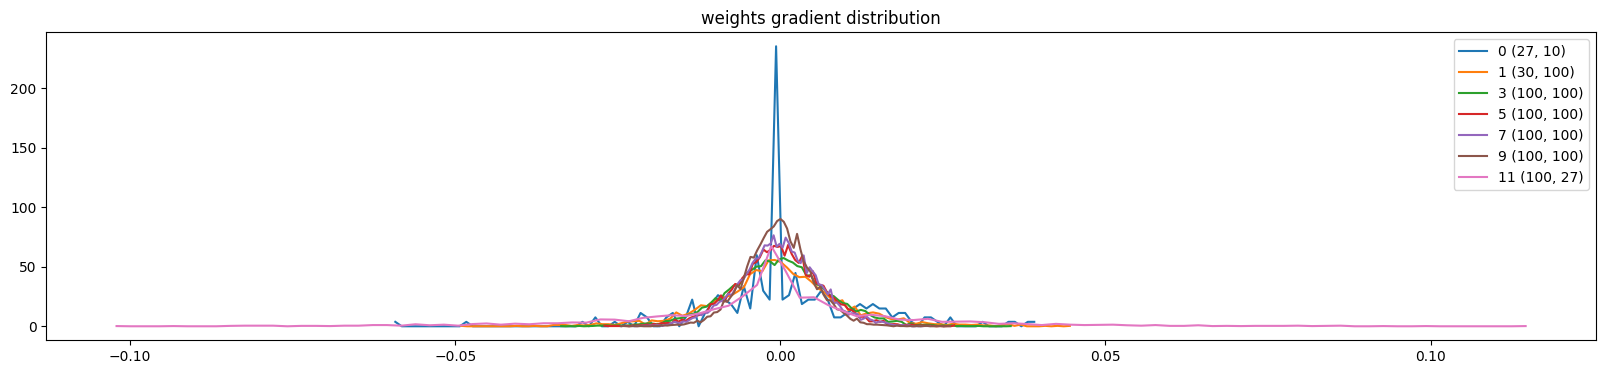

In [86]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

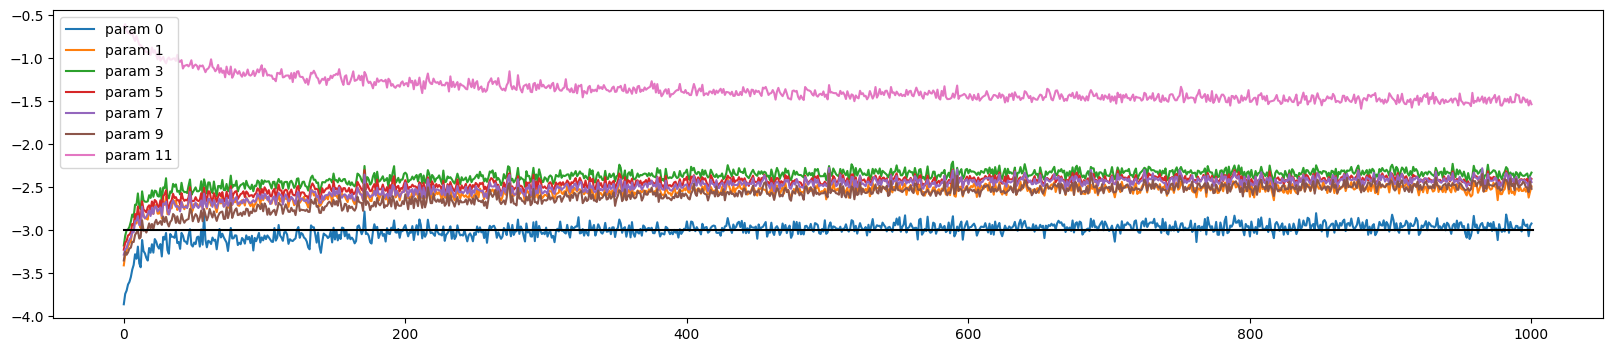

In [87]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);